# Особенности V0.2

Здесь для расчётов было взято каждое 10 значение (из 360). Не то, чтобы это сильно улучшило или ускорило вычисления.



#Что это такое:


Это попытка применения VAE в качестве суррогатной модели для SEIR. Суррогатная модель должна обучиться на наборах данных (параметры + список инфицированных по дням), чтобы в дальнейшем предсказывать списки инфицированных, принимая лишь параметры.

 SEIR была выбрана, так как сэмплирование для мультагентной модели не работало: на малых наборах данных код для мультиагнетной просто не работал и не получалсь нагенерить данные.

Почему VAE?


VAE была предложена предыдущим работником, аргументировано это тем, что данная глубокая нейронная сеть может учитывать стохастичность данных и потому отлично подойдет для их генерации.

В данной работе на один набор параметров всего один график, однако в теории можно сделать на каждый набор параметров по несколько графиков и это должно работать (дисперсия будет чуть больше, но мб точность на малых значениях повысится).

В качестве тренировочных данных были взяты параметры от 0.1 до 1 c шагом в 0.1, а в качестве тренировочных - от 0.05 до 0.95 с шагом в 0.1. Идея в том, что модель должна адекватно предсказывать значения, которых нет в тренировочной.


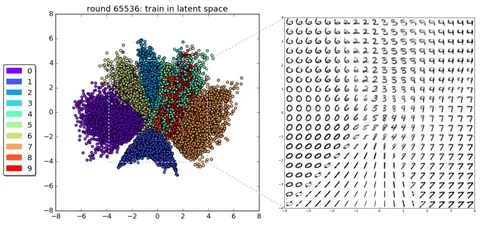



Достигается это использованием среднеквадратических отклонений и матожиданий.
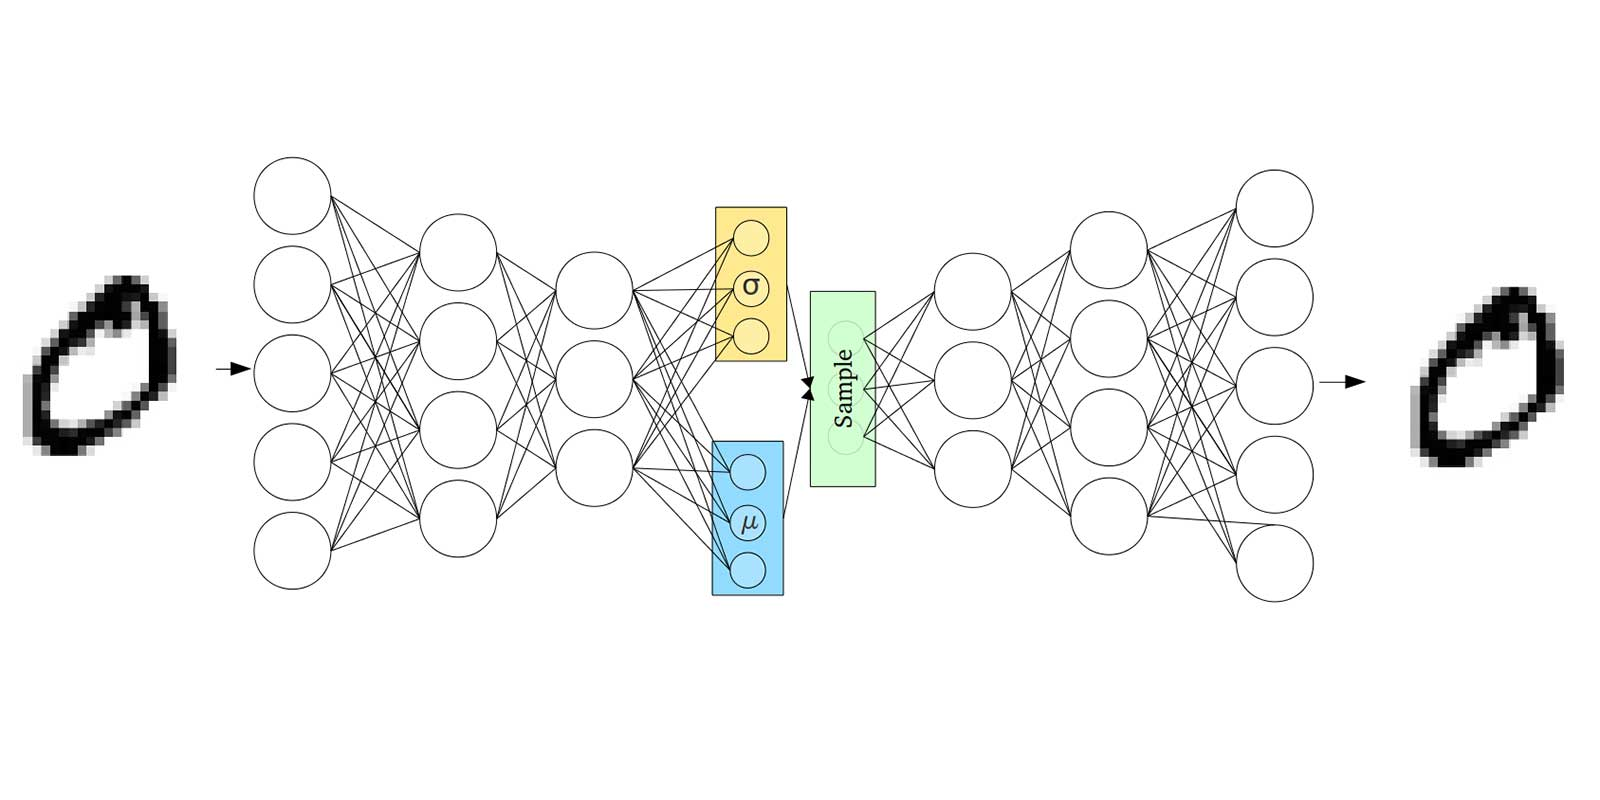

#Проблемы и решения

1) В этой работе я столкнулся с тем, что если подавать графики вразнобой (при постепенном изменении параметров, даже на 0.1, графики могут резко как повышаться, так и понижаться, а также смещать свой пик, что приводит к тому, что постепенное увеличение параметров вовсе не ведет к плавному изменению количества инфицированных), VAE обучается плохо. Я отсортировал их по максимальному значению инфицированных и по тому, как рано они начинаются (сначала идут пики, которые проявляются рано, а их значение мало, потом они увеличиваются, смещаясь вправо - к более поздним датам), таким образом, если построить график один за другим, то изменение будет проходить плавно.

То есть больше параметры != больше инфицированных, по крайней мере для SEIR.


---


2) Для VAE проблема довольно банальна: модель плохо предсказывает для маленьких значений (допустим около 1 000-10 000) и очень хорошо для больших (100 000 - 1 500 000).

**Как решить.** Убрать те строки, где количество на второй день меньше 10 (мб можно взять и больше).


---


3) Скорость и сложность обучения. Очевидно, если домножить нашу функцию на 100000 она будет вычислять большие значения гораздо быстрее, чем раньше, однако всё ещё есть проблема с предсказанием малых значений.

**Как решить.** Просто не обучать на данных, где пиковая заболеваемость меньше, чем, например 0.001% от населения.



---

4) Нормализация и стандартизация лишь ухудшили ситуацию. Тут есть нормализованные данные, можно обучиться на них (поменять y_train и y_test на y_train_normalized и y_test_normalized

# Комментарии по VAE

#Импорты

In [ ]:
!pip install torchmetrics pytorch_lightning > None

In [ ]:
!pip install tensorboard > None

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#1. Генерация набора

##1.1 Генерация train

Train будет на параметрах, значения которых принимают значения от 0 до 1 с интервалом в 0.1

In [ ]:
beta = [round(0.1 * i, 1) for i in range(1, 11)]
sigma = [round(0.1 * i, 1) for i in range(1, 11)]
gamma = [round(0.1 * i, 1) for i in range(1, 11)]

print("beta:", beta)
print("sigma:", sigma)
print("gamma:", gamma)

beta: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sigma: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [ ]:
# Генерация списков alfa, beta и gamma
beta = [round(0.1 * i, 1) for i in range(1, 11)]
sigma = [round(0.1 * i, 1) for i in range(1, 11)]
gamma = [round(0.1 * i, 1) for i in range(1, 11)]

# Создание всех возможных комбинаций
combinations = list(product(beta, sigma, gamma))

# Создание DataFrame
df = pd.DataFrame(combinations, columns=['beta', 'sigma', 'gamma'])

print(df)

     beta  sigma  gamma
0     0.1    0.1    0.1
1     0.1    0.1    0.2
2     0.1    0.1    0.3
3     0.1    0.1    0.4
4     0.1    0.1    0.5
..    ...    ...    ...
995   1.0    1.0    0.6
996   1.0    1.0    0.7
997   1.0    1.0    0.8
998   1.0    1.0    0.9
999   1.0    1.0    1.0

[1000 rows x 3 columns]


In [ ]:
import numpy as np

def seir_model(beta, sigma, gamma, N, I0, E0, R0, days):
    S = np.zeros(days, dtype=float)
    E = np.zeros(days, dtype=float)
    I = np.zeros(days, dtype=float)
    R = np.zeros(days, dtype=float)

    S[0] = N - I0 - E0 - R0
    E[0] = E0
    I[0] = I0
    R[0] = R0

    for day in range(1, days):
        dS = -beta * S[day - 1] * I[day - 1] / N
        dE = beta * S[day - 1] * I[day - 1] / N - sigma * E[day - 1]
        dI = sigma * E[day - 1] - gamma * I[day - 1]
        dR = gamma * I[day - 1]

        S[day] = max(0, S[day - 1] + dS)
        E[day] = max(0, E[day - 1] + dE)
        I[day] = max(0, I[day - 1] + dI)
        R[day] = max(0, R[day - 1] + dR)

    return S, E, I, R

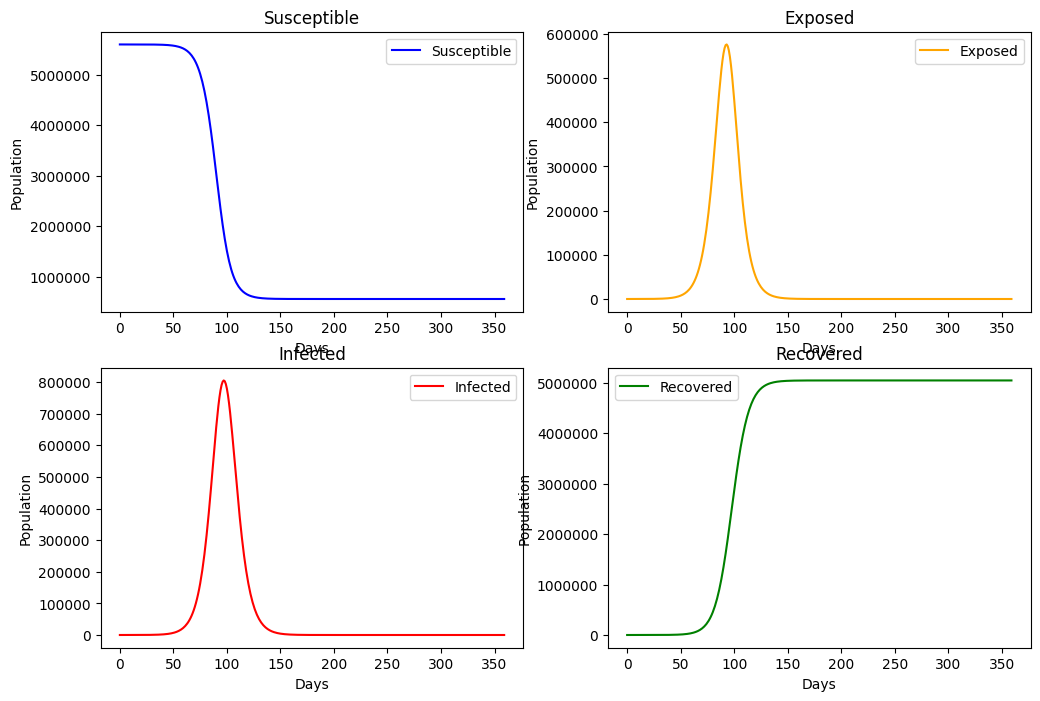

In [ ]:
# Пример использования функции
beta = 0.5   # коэффициент контакта
sigma = 0.3  # обратное время инкубационного периода
gamma = 0.2 # обратное время выздоровления
N = 5600044     # общее количество населения
E0 = 10       # начальное количество скрытых инфицированных
I0 = 10       # начальное количество инфицированных
R0 = 0       # начальное количество выздоровевших
days = 360   # количество дней моделирования

S, E, I, R = seir_model(beta, sigma, gamma, N, I0, E0, R0, days)

# Создание отдельных графиков
plt.figure(figsize=(12, 8))


# График для подверженных (Susceptible)
plt.subplot(2, 2, 1)
plt.plot(S, label='Susceptible', color='blue')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('Susceptible')
plt.ticklabel_format(style='plain')  # Отключение научной нотации
plt.legend()

# График для скрытых инфицированных (Exposed)
plt.subplot(2, 2, 2)
plt.plot(E, label='Exposed', color='orange')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('Exposed')
plt.ticklabel_format(style='plain')  # Отключение научной нотации
plt.legend()

# График для активных инфицированных (Infected)
plt.subplot(2, 2, 3)
plt.plot(I, label='Infected', color='red')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('Infected')
plt.ticklabel_format(style='plain')  # Отключение научной нотации
plt.legend()

# График для выздоровевших (Recovered)
plt.subplot(2, 2, 4)
plt.plot(R, label='Recovered', color='green')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('Recovered')
plt.ticklabel_format(style='plain')  # Отключение научной нотации
plt.legend()

In [ ]:
# Функция для применения модели к каждой строке датасета
def simulate_epidemic(row):
    beta = row['beta']
    sigma = row['sigma']
    gamma = row['gamma']

    N = 5600044     # общее количество населения
    I0 = 10       # начальное количество инфицированных
    E0 = 10      # начальное количество скрытых инфицированных
    R0 = 0       # начальное количество выздоровевших
    days = 360   # количество дней моделирования

    _, _, infected, _ = seir_model(beta, sigma, gamma, N, I0, E0, R0, days)
    return infected.tolist()

In [ ]:
df['I'] = df.apply(simulate_epidemic, axis=1)

In [ ]:
df

,beta,sigma,gamma,I
0,0.1,0.1,0.1,"[10.0, 10.0, 9.99999964285995, 9.9999989821509..."
1,0.1,0.1,0.2,"[10.0, 9.0, 8.199999642859948, 7.5499990553646..."
2,0.1,0.1,0.3,"[10.0, 8.0, 6.599999642859949, 5.5999991285783..."
3,0.1,0.1,0.4,"[10.0, 7.0, 5.199999642859948, 4.0899992017920..."
4,0.1,0.1,0.5,"[10.0, 6.0, 3.999999642859949, 2.9599992750057..."
...,...,...,...,...
995,1.0,1.0,0.6,"[10.0, 14.0, 15.599964285994895, 20.2399107150..."
996,1.0,1.0,0.7,"[10.0, 13.0, 13.899964285994896, 17.1699196435..."
997,1.0,1.0,0.8,"[10.0, 12.0, 12.399964285994894, 14.4799285720..."
998,1.0,1.0,0.9,"[10.0, 11.0, 11.099964285994895, 12.1099375005..."


In [ ]:
len(df.loc[0, 'I'] )

360

In [ ]:
x = [i for i in range(360)]

Text(0, 0.5, 'Кол-во инфицированных')

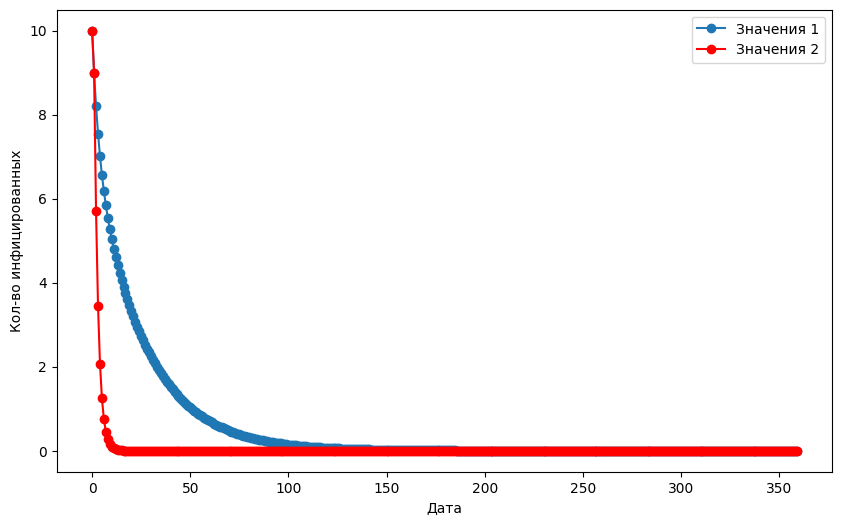

In [ ]:
# Проверяем, что значения для комбинаций коэффициентов разные
plt.figure(figsize=(10,6))
plt.plot(x, df.I[1], marker='o', linestyle='-', label='Значения 1')
plt.plot(x, df.I[56], marker='o', linestyle='-', color = 'red', label='Значения 2')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кол-во инфицированных')

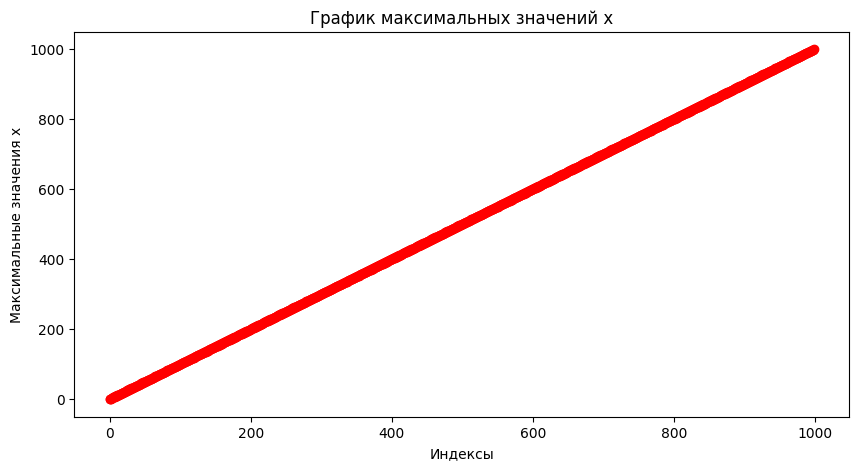

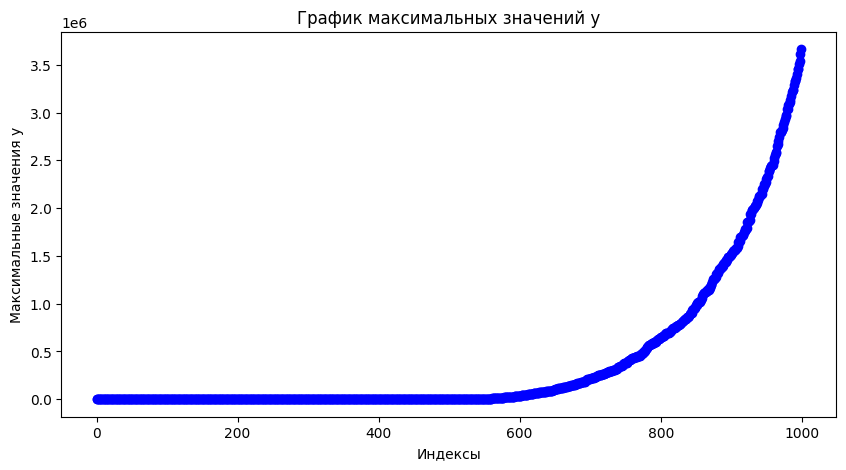

In [ ]:
df['Max_Y'] = df['I'].apply(lambda x: max(x))
df['Max_X'] = df['Max_Y'].index

# Сортируем DataFrame по максимальному значению x и максимальному значению y
sorted_df = df.sort_values(by=['Max_Y', 'Max_X', ], ascending=[True, True])

# Выводим график максимальных значений x
# То есть тут мы сортируем по тому, как поздно у нас проявляется максимальное
# значение инфицированных: просто графики, где пик справа, теперь соседствуют с теми,
# где пик тоже справа
plt.figure(figsize=(10, 5))
plt.plot(sorted_df['Max_X'], marker='o', linestyle='-', color='red')
plt.title('График максимальных значений x')
plt.xlabel('Индексы')
plt.ylabel('Максимальные значения x')
plt.show()
sorted_df.reset_index(drop=True, inplace=True)

# Выводим график максимальных значений y
# Тут просто сортируем по пиковому числу инфицированных
plt.figure(figsize=(10, 5))
plt.plot(sorted_df['Max_Y'], marker='o', linestyle='-', color='blue')
plt.title('График максимальных значений y')
plt.xlabel('Индексы')
plt.ylabel('Максимальные значения y')
plt.show()

Text(0, 0.5, 'Кол-во инфицированных')

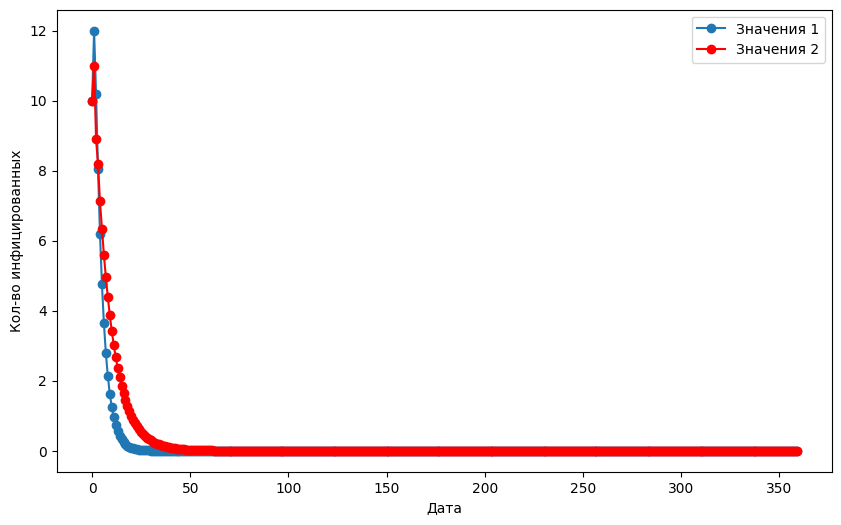

In [ ]:
# Проверяем, что значения для комбинаций коэффициентов разные
plt.figure(figsize=(10,6))
plt.plot(x, sorted_df.I[430], marker='o', linestyle='-', label='Значения 1')
plt.plot(x, sorted_df.I[412], marker='o', linestyle='-', color = 'red', label='Значения 2')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кол-во инфицированных')

In [ ]:
sorted_df

,beta,sigma,gamma,I,Max_Y,Max_X
0,0.1,0.1,0.1,"[10.0, 10.0, 9.99999964285995, 9.9999989821509...",1.000000e+01,0
1,0.1,0.1,0.2,"[10.0, 9.0, 8.199999642859948, 7.5499990553646...",1.000000e+01,1
2,0.1,0.1,0.3,"[10.0, 8.0, 6.599999642859949, 5.5999991285783...",1.000000e+01,2
3,0.1,0.1,0.4,"[10.0, 7.0, 5.199999642859948, 4.0899992017920...",1.000000e+01,3
4,0.1,0.1,0.5,"[10.0, 6.0, 3.999999642859949, 2.9599992750057...",1.000000e+01,4
...,...,...,...,...,...,...
995,0.9,0.9,0.1,"[10.0, 18.0, 25.199971071655867, 38.1598955687...",3.452595e+06,880
996,0.9,1.0,0.1,"[10.0, 19.0, 26.099967857395406, 40.5898825188...",3.505745e+06,890
997,1.0,0.8,0.1,"[10.0, 17.0, 24.899971428795915, 37.9298957151...",3.543020e+06,970
998,1.0,0.9,0.1,"[10.0, 18.0, 26.099967857395406, 40.6798810724...",3.614093e+06,980


In [ ]:
sorted_df.drop(columns=['Max_X', 'Max_Y'], inplace=True)

In [ ]:
sorted_df

,beta,sigma,gamma,I
0,0.1,0.1,0.1,"[10.0, 10.0, 9.99999964285995, 9.9999989821509..."
1,0.1,0.1,0.2,"[10.0, 9.0, 8.199999642859948, 7.5499990553646..."
2,0.1,0.1,0.3,"[10.0, 8.0, 6.599999642859949, 5.5999991285783..."
3,0.1,0.1,0.4,"[10.0, 7.0, 5.199999642859948, 4.0899992017920..."
4,0.1,0.1,0.5,"[10.0, 6.0, 3.999999642859949, 2.9599992750057..."
...,...,...,...,...
995,0.9,0.9,0.1,"[10.0, 18.0, 25.199971071655867, 38.1598955687..."
996,0.9,1.0,0.1,"[10.0, 19.0, 26.099967857395406, 40.5898825188..."
997,1.0,0.8,0.1,"[10.0, 17.0, 24.899971428795915, 37.9298957151..."
998,1.0,0.9,0.1,"[10.0, 18.0, 26.099967857395406, 40.6798810724..."


In [ ]:
# Тут отбирается каждое десятое значение. Можно убрать и получить списки длиной 360
# При изменении не забудь поменять output_size (см. VAE)!
def select_tenth_value(lst):
    return lst[::10]

# Применение функции к столбцу I
sorted_df['selected_values'] = sorted_df['I'].apply(select_tenth_value)

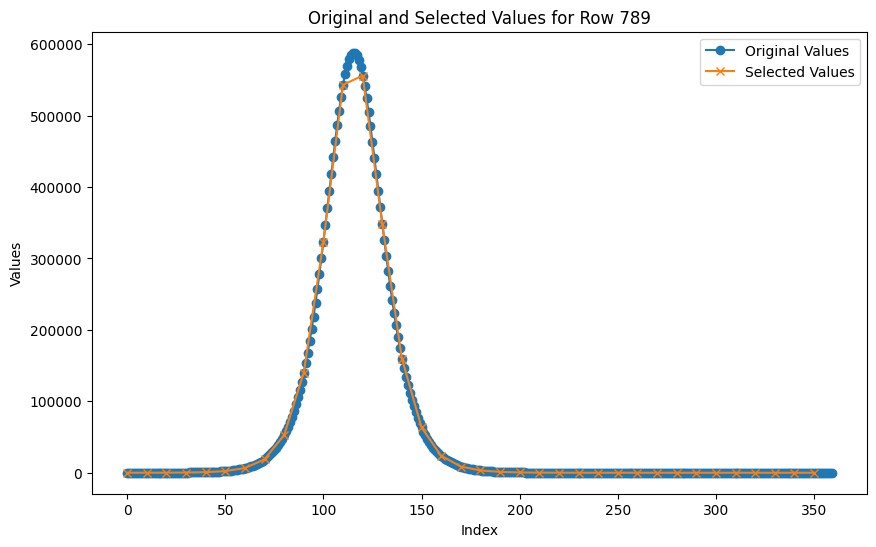

In [ ]:
# Визуализация оригинальных данных и разреженных (выбрана каждая 10 точка)

# Выбираем одну строку и ее значение из столбца I
selected_row_index = 789  # Индекс строки, которую вы хотите выбрать
selected_row = sorted_df.loc[selected_row_index, 'I']
selected_values = sorted_df.loc[selected_row_index, 'selected_values']

# Визуализация результатов
fig, ax = plt.subplots(figsize=(10, 6))

# Построение графика для исходного значения и выбранных значений
ax.plot(selected_row, label='Original Values', marker='o')
ax.plot(range(0, len(selected_row), 10), selected_values, label='Selected Values', marker='x')

ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title(f'Original and Selected Values for Row {selected_row_index}')
ax.legend()

plt.show()

In [ ]:
sorted_df.drop('I', axis=1, inplace=True)
sorted_df.rename(columns={'selected_values': 'I'}, inplace=True)

In [ ]:
sorted_df

,beta,sigma,gamma,I
0,0.1,0.1,0.1,"[10.0, 9.999988566789048, 9.999962869604735, 9..."
1,0.1,0.1,0.2,"[10.0, 5.034722896890047, 3.3270636022525615, ..."
2,0.1,0.1,0.3,"[10.0, 2.810815729724845, 1.4962066752771586, ..."
3,0.1,0.1,0.4,"[10.0, 1.7769825233419563, 0.8515104973075821,..."
4,0.1,0.1,0.5,"[10.0, 1.252883968515229, 0.5639892296846201, ..."
...,...,...,...,...
995,0.9,0.9,0.1,"[10.0, 604.4263291749023, 31362.93130140139, 1..."
996,0.9,1.0,0.1,"[10.0, 686.4156322662925, 39375.253511004565, ..."
997,1.0,0.8,0.1,"[10.0, 679.1165881211608, 41748.97156307114, 1..."
998,1.0,0.9,0.1,"[10.0, 792.9036586057474, 55181.362334611295, ..."


In [ ]:
# не помню что это
# def get_max_value(lst):
#     return max(lst)

# # Применение функции к столбцу 'I' и сортировка значений
# maxes_sorted = df['I'].apply(get_max_value).sort_values()
# x_values = list(range(1000))
# # Построение отсортированной столбчатой диаграммы
# plt.figure(figsize=(8, 6))
# plt.bar(x_values, maxes_sorted, color='blue')
# plt.xlabel('Индекс списка')
# plt.ylabel('Максимальное значение')
# plt.title('Максимальные значения в каждом списке (отсортированные)')
# plt.show()

In [ ]:
#train = df.copy()
train = sorted_df.copy()

In [ ]:
df_values = train['I'].apply(pd.Series)
train_new = pd.concat([train.iloc[:, :3], df_values], axis=1)

In [ ]:
train_new.head()

,beta,sigma,gamma,0,1,2,3,4,5,6,...,26,27,28,29,30,31,32,33,34,35
0,0.1,0.1,0.1,10.0,9.999989,9.999963,9.999928,9.999883,9.999830,9.999768,...,9.996653e+00,9.996404e+00,9.996145e+00,9.995878e+00,9.995602e+00,9.995317e+00,9.995023e+00,9.994720e+00,9.994408e+00,9.994087e+00
1,0.1,0.1,0.2,10.0,5.034723,3.327064,2.249823,1.523896,1.032317,0.699318,...,2.896726e-04,1.962316e-04,1.329323e-04,9.005177e-05,6.100338e-05,4.132525e-05,2.799479e-05,1.896439e-05,1.284696e-05,8.702861e-06
2,0.1,0.1,0.3,10.0,2.810816,1.496207,0.817521,0.447022,0.244438,0.133662,...,7.634837e-07,4.174836e-07,2.282858e-07,1.248299e-07,6.825872e-08,3.732482e-08,2.040973e-08,1.116033e-08,6.102622e-09,3.336999e-09
3,0.1,0.1,0.4,10.0,1.776983,0.851510,0.413307,0.200631,0.097392,0.047277,...,2.495423e-08,1.211348e-08,5.880225e-09,2.854426e-09,1.385618e-09,6.726180e-10,3.265076e-10,1.584960e-10,7.693838e-11,3.734805e-11
4,0.1,0.1,0.5,10.0,1.252884,0.563989,0.254765,0.115083,0.051985,0.023483,...,2.938776e-09,1.327508e-09,5.996640e-10,2.708811e-10,1.223628e-10,5.527391e-11,2.496841e-11,1.127877e-11,5.094862e-12,2.301458e-12


##1.2 Генерация test

In [ ]:
beta = [round(0.05 + 0.1 * i, 2) for i in range(10)]
sigma = [round(0.05 + 0.1 * i, 2) for i in range(10)]
gamma = [round(0.05 + 0.1 * i, 2) for i in range(10)]

print("beta:", beta)
print("sigma:", sigma)
print("gamma:", gamma)

beta: [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
sigma: [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
gamma: [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]


In [ ]:
# Генерация списков alfa, beta и gamma
beta = [round(0.05 + 0.1 * i, 2) for i in range(10)]
sigma = [round(0.05 + 0.1 * i, 2) for i in range(10)]
gamma = [round(0.05 + 0.1 * i, 2) for i in range(10)]

# Создание всех возможных комбинаций
combinations = list(product(beta, sigma, gamma))

# Создание DataFrame
df = pd.DataFrame(combinations, columns=['beta', 'sigma', 'gamma'])

print(df)

     beta  sigma  gamma
0    0.05   0.05   0.05
1    0.05   0.05   0.15
2    0.05   0.05   0.25
3    0.05   0.05   0.35
4    0.05   0.05   0.45
..    ...    ...    ...
995  0.95   0.95   0.55
996  0.95   0.95   0.65
997  0.95   0.95   0.75
998  0.95   0.95   0.85
999  0.95   0.95   0.95

[1000 rows x 3 columns]


In [ ]:
# Функция для применения модели к каждой строке датасета
def simulate_epidemic(row):
    beta = row['beta']
    sigma = row['sigma']
    gamma = row['gamma']

    N = 5600044     # общее количество населения
    I0 = 10       # начальное количество инфицированных
    E0 = 10      # начальное количество скрытых инфицированных
    R0 = 0       # начальное количество выздоровевших
    days = 360   # количество дней моделирования

    _, _, infected, _ = seir_model(beta, sigma, gamma, N, I0, E0, R0, days)
    return infected.tolist()

In [ ]:
df['I'] = df.apply(simulate_epidemic, axis=1)

In [ ]:
# Применение функции к столбцу I
df['selected_values'] = df['I'].apply(select_tenth_value)

In [ ]:
df.loc[(df.beta == 0.15) & (df.sigma == 0.25) & (df.gamma == 0.05)]

,beta,sigma,gamma,I,selected_values
120,0.15,0.25,0.05,"[10.0, 12.0, 13.649998660724808, 15.1049959955...","[10.0, 25.112161311394384, 48.517598406449736,..."


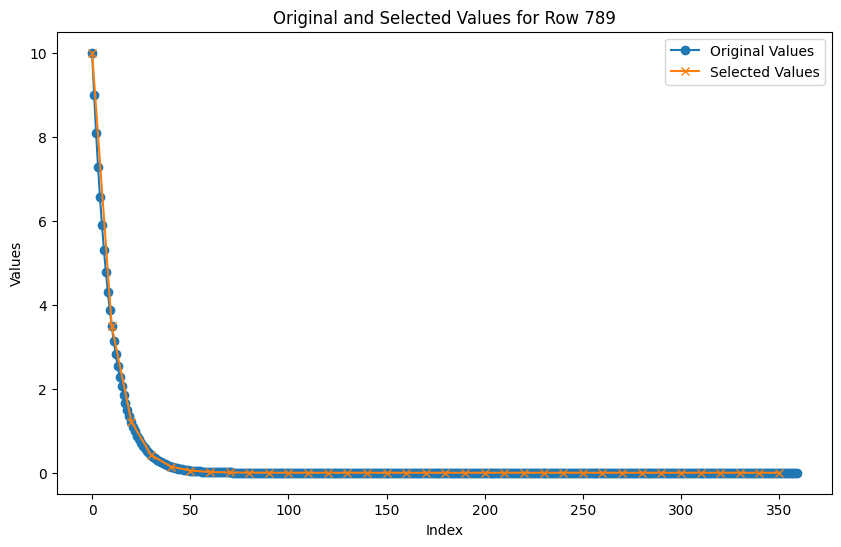

In [ ]:
# Выбираем одну строку и ее значение из столбца I
selected_row_index = 789  # Индекс строки, которую вы хотите выбрать
selected_row = df.loc[selected_row_index, 'I']
selected_values = df.loc[selected_row_index, 'selected_values']

# Визуализация результатов
fig, ax = plt.subplots(figsize=(10, 6))

# Построение графика для исходного значения и выбранных значений
ax.plot(selected_row, label='Original Values', marker='o')
ax.plot(range(0, len(selected_row), 10), selected_values, label='Selected Values', marker='x')

# Добавление подписей и легенды
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title(f'Original and Selected Values for Row {selected_row_index}')
ax.legend()

# Отображение графика
plt.show()

In [ ]:
df.drop('I', axis=1, inplace=True)
df.rename(columns={'selected_values': 'I'}, inplace=True)

In [ ]:
test = df.copy()

In [ ]:
df_values = test['I'].apply(pd.Series)
test_new = pd.concat([test.iloc[:, :3], df_values], axis=1)

In [ ]:
test_new.head()

,beta,sigma,gamma,0,1,2,3,4,5,6,...,26,27,28,29,30,31,32,33,34,35
0,0.05,0.05,0.05,10.0,9.999997,9.999988,9.999977,9.999962,9.999946,9.999927,...,9.999081,9.999015,9.998947,9.998877,9.998805,9.998730,9.998653e+00,9.998574e+00,9.998493e+00,9.998409e+00
1,0.05,0.05,0.15,10.0,4.483407,2.877417,2.067776,1.525313,1.131420,0.840215,...,0.002199,0.001634,0.001214,0.000902,0.000670,0.000498,3.695687e-04,2.745319e-04,2.039344e-04,1.514915e-04
2,0.05,0.05,0.25,10.0,2.220078,1.285099,0.860046,0.582113,0.394315,0.267119,...,0.000111,0.000075,0.000051,0.000034,0.000023,0.000016,1.069396e-05,7.244382e-06,4.907544e-06,3.324506e-06
3,0.05,0.05,0.35,10.0,1.294899,0.782099,0.509102,0.331868,0.216339,0.141028,...,0.000027,0.000018,0.000012,0.000008,0.000005,0.000003,2.078536e-06,1.354967e-06,8.832832e-07,5.757993e-07
4,0.05,0.05,0.45,10.0,0.889412,0.555609,0.354829,0.226622,0.144739,0.092442,...,0.000012,0.000008,0.000005,0.000003,0.000002,0.000001,8.003124e-07,5.111445e-07,3.264584e-07,2.085029e-07


##Делим данные

In [ ]:
X_train = train[['beta', 'sigma', 'gamma']]
y_train = train_new.iloc[:, 3:]
X_test = test[['beta', 'sigma', 'gamma']]
y_test = test_new.iloc[:, 3:]

In [ ]:
scaler = MinMaxScaler()

# Нормализуем, применительно ко всем строкам
y_train_normalized = pd.DataFrame(scaler.fit_transform(y_train), columns=y_train.columns)
y_test_normalized = pd.DataFrame(scaler.fit_transform(y_test), columns=y_test.columns)

In [ ]:
y_test_normalized

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.0,0.010635,0.000133,2.968881e-06,2.425088e-06,2.661162e-06,2.894981e-06,3.151911e-06,3.357631e-06,3.724173e-06,...,1.114407e-05,1.435149e-05,1.906824e-05,2.605991e-05,3.340391e-05,2.559519e-05,2.023116e-05,1.660766e-05,1.424528e-05,1.282535e-05
1,0.0,0.004768,0.000038,6.138994e-07,3.699032e-07,3.010909e-07,2.432425e-07,1.967157e-07,1.556651e-07,1.282583e-07,...,2.451281e-09,2.345020e-09,2.314519e-09,2.349762e-09,2.237428e-09,1.273535e-09,7.477812e-10,4.559982e-10,2.905541e-10,1.943239e-10
2,0.0,0.002361,0.000017,2.553379e-07,1.411681e-07,1.049342e-07,7.733096e-08,5.703551e-08,4.115932e-08,3.092637e-08,...,1.233233e-10,1.075880e-10,9.683745e-11,8.965439e-11,7.785061e-11,4.041003e-11,2.163804e-11,1.203294e-11,6.991989e-12,4.264472e-12
3,0.0,0.001377,0.000010,1.511467e-07,8.048108e-08,5.757173e-08,4.082777e-08,2.897718e-08,2.012275e-08,1.454978e-08,...,3.018661e-11,2.534203e-11,2.194973e-11,1.955535e-11,1.634047e-11,8.162062e-12,4.205687e-12,2.250604e-12,1.258451e-12,7.386000e-13
4,0.0,0.000946,0.000007,1.053446e-07,5.495811e-08,3.851771e-08,2.676208e-08,1.860944e-08,1.266128e-08,8.969322e-09,...,1.314130e-11,1.080882e-11,9.172317e-12,8.006240e-12,6.554513e-12,3.207664e-12,1.619343e-12,8.490123e-13,4.651193e-13,2.674547e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.085385,0.007848,1.283398e-03,7.467935e-03,4.820578e-02,1.132982e-01,3.574591e-02,4.281297e-03,4.639555e-04,...,7.158564e-21,8.865743e-22,1.132831e-22,1.488894e-23,1.835375e-24,1.352454e-25,1.028068e-26,8.116073e-28,6.694921e-29,5.796696e-30
996,0.0,0.051005,0.002858,2.853537e-04,1.035781e-03,4.914128e-03,2.055417e-02,5.571953e-02,5.273280e-02,1.811405e-02,...,1.261803e-14,2.910464e-15,6.926179e-16,1.695407e-16,3.892392e-17,5.341899e-18,7.562694e-19,1.111943e-19,1.708297e-20,2.754736e-21
997,0.0,0.030301,0.001032,6.265431e-05,1.389119e-04,4.121610e-04,1.199815e-03,3.399874e-03,8.771621e-03,1.981701e-02,...,1.035020e-08,4.427310e-09,1.953852e-09,8.869359e-10,3.776200e-10,9.610686e-11,2.523222e-11,6.879891e-12,1.960121e-12,5.861648e-13
998,0.0,0.017935,0.000371,1.365437e-05,1.838420e-05,3.323335e-05,5.950322e-05,1.064671e-04,1.859349e-04,3.367485e-04,...,9.129301e-04,7.019854e-04,5.546261e-04,4.496375e-04,3.413961e-04,1.548171e-04,7.238698e-05,3.513959e-05,1.782096e-05,9.485392e-06


#VAE

**Примечание**

Тут я не использую нормализированные данные - результат получается гораздо хуже

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torchmetrics import MeanSquaredError
from pytorch_lightning import LightningModule, Trainer
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Преобразование данных в torch.Tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
import torch

# Проверьте доступность CUDA (GPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU доступен.")
else:
    device = torch.device("cpu")
    print("GPU недоступен, используется CPU.")

GPU доступен.


**Комментарий**

Я использовал архитектуру, когда мы обучаем нашу модель на X = alfa, beta gamma и y = список инфицированных. Предсказание происходит, если на вход подаются параметры.

Тут я игрался с параметрами, сейчас в модели вроде адекватные

In [ ]:
# Определение модели VAE с использованием PyTorch Lightning
class VAE(LightningModule):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc3_1 = nn.Linear(hidden_size, hidden_size)

        self.fc4 = nn.Linear(hidden_size, output_size)
        self.loss = nn.MSELoss()
        self.metrics = MeanSquaredError()

        # Вывод информации о слоях в TensorBoard
        self.log_hidden_size = hidden_size
        self.log_latent_size = latent_size

        nn.init.normal_(self.fc4.weight, mean=0, std=0.01)

         # Ограничение дисперсии - очень полезная штука
        self.max_logvar = nn.Parameter(torch.ones(latent_size) * 0.5, requires_grad=True)###
        self.min_logvar = nn.Parameter(torch.ones(latent_size) * -0.5, requires_grad=True)###


    def encode(self, x):
        h = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        h = F.leaky_relu(self.fc2(h), negative_slope=0.01)
        return self.fc21(h), self.fc22(h)


    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=self.min_logvar, max=self.max_logvar) ###
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z):
        h = F.leaky_relu(self.fc3(z), negative_slope=0.01)
        h = F.leaky_relu(self.fc3_1(h), negative_slope=0.01)
        #return self.fc4(h)
        return F.relu(self.fc4(h)) # Позволяет избежать отрицательных значений
        # в предсказаниях

    def forward(self, x):

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


    def training_step(self, batch, batch_idx):
        x, y = batch
        output, mu, logvar = self(x)

        # Вычисление MSE loss
        reconstruction_loss = self.loss(output, y)

        # KL-дивергенция
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Общая функция потерь
        loss = reconstruction_loss + kl_divergence

        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001, weight_decay=0.00000001) #0.00000001


    def predict(self, custom_data):
      # Преобразование кастомных данных в тензор
      custom_data_tensor = torch.tensor(custom_data, dtype=torch.float32)
      custom_data_tensor = custom_data_tensor.to(self.device)  # Перенос на устройство (GPU, если используется)

      self.eval()

      # Получение предсказаний с кастомными данными
      with torch.no_grad():
        custom_predictions, _, _ = self(custom_data_tensor)

      # Вернуть модель в режим обучения (train), если это необходимо
      self.train()

      # Преобразование тензора предсказаний в список
      custom_predictions_list = custom_predictions.tolist()

      return custom_predictions_list

In [ ]:
logger = TensorBoardLogger("logs", name="my_experiment")

**Комментарий**

А вот тут уже можно поиграться с количеством эпох, размером батча и прочим.

 Оптимальные значения:

 * batch_size = 30/64
 * hidden_size = 512/1024
 * latent_size = 256/512
 * max_epochs = не менее 500, с учётом ограниченной дисперсии даже на 12000 получалось что-то симпотичное

 log_every_n_steps должен иметь размер batch_size

In [ ]:
# Создание DataLoader для обучения
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Инициализация модели
model = VAE(input_size=3, hidden_size=512, latent_size=256, output_size=36)
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

In [ ]:
# Обучение модели
trainer = Trainer(max_epochs=500, log_every_n_steps=32, logger=logger)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | fc1          | Linear           | 2.0 K 
1 | fc2          | Linear           | 262 K 
2 | fc21         | Linear           | 131 K 
3 | fc22         | Linear           | 131 K 
4 | fc3          | Linear           | 131 K 
5 | fc3_1        | Linear           | 262 K 
6 | fc4          | Linear           | 18.5 K
7 | loss         | MSELoss          | 0     
8 | metrics      | MeanSquaredError | 0     
  | other params | n/a              | 512   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


In [ ]:
with torch.no_grad():
    model.eval()
    test_output, _, _ = model(X_test_tensor)
    test_loss = model.loss(test_output, y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')

Test Loss: 7628274688.0


In [ ]:
with torch.no_grad():
    model.eval()
    test_output, _, _ = model(X_test_tensor)

    # Преобразование тензоров в numpy массивы
    y_true = y_test_tensor.cpu().numpy()
    y_pred = test_output.cpu().numpy()

    # Вычисление R^2
    r2_value = r2_score(y_true, y_pred)

    print(f'R^2 Score: {r2_value}')

R^2 Score: 0.6002867875901087


In [ ]:
# Сохраняем модель
#torch.save(model.state_dict(), 'R2_-1202.pth')
# Загружаем модель
# loaded_model = VAE(input_size=3, hidden_size=3604, latent_size=512, output_size=101)
# loaded_model.load_state_dict(torch.load('your_model.pth'))
# loaded_model.eval()

##Тесты

###Тест 1

In [ ]:
x = [i for i in range(360)]

In [ ]:
custom_data_input = [0.1, 0.1, 0.1]
custom_data_input = [0.35, 0.16, 0.09]
#custom_data_input = [0.9, 0.9, 0.1]
custom_predictions = model.predict(custom_data_input)

In [ ]:
# Пример использования функции
N = 5600044
E0 = 10
I0 = 10
R0 = 0
days = 360

S, E, I, R = seir_model(*custom_data_input, N, I0, E0, R0, days)

In [ ]:
I = I[::10]

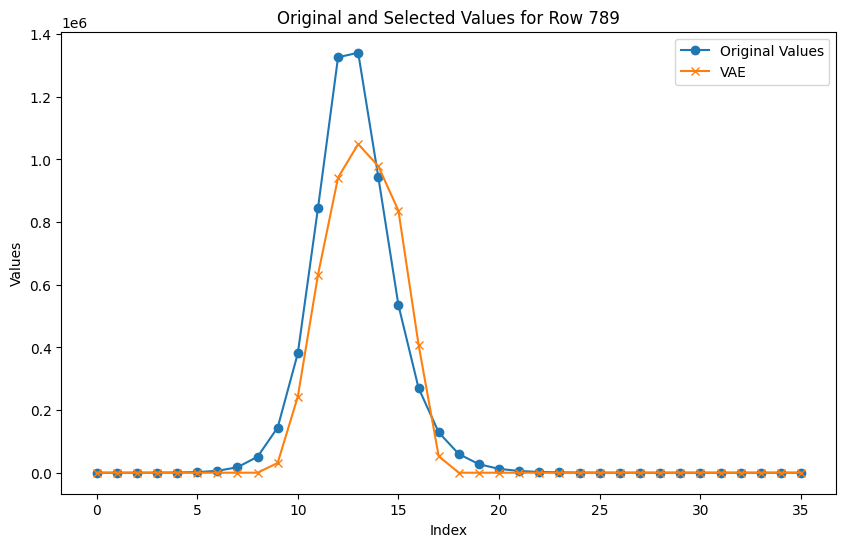

In [ ]:
# Визуализация результатов
fig, ax = plt.subplots(figsize=(10, 6))

# Построение графика для исходного значения и выбранных значений
ax.plot(I, label='Original Values', marker='o')
ax.plot(range(len(I)), custom_predictions, label='VAE', marker='x')

# Добавление подписей и легенды
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title(f'Original and Selected Values for Row {selected_row_index}')
ax.legend()

# Отображение графика
plt.show()

In [ ]:
coefs = [*custom_data_input, N, days]

In [ ]:
r2_score(I, custom_predictions)

0.9071128042125308

###Тест 2

In [ ]:
custom_data_input = [0.2, 0.1, 0.1]
#custom_data_input = [0.35, 0.16, 0.09]
#custom_data_input = [0.9, 0.9, 0.1]
custom_predictions = model.predict(custom_data_input)

In [ ]:
# Пример использования функции
N = 5600044
E0 = 10
I0 = 10
R0 = 0
days = 360

S, E, I, R = seir_model(*custom_data_input, N, I0, E0, R0, days)
I = I[::10]

In [ ]:
coefs = [*custom_data_input, N, days]

In [ ]:
r2_score(I, custom_predictions)

0.9136929306354751

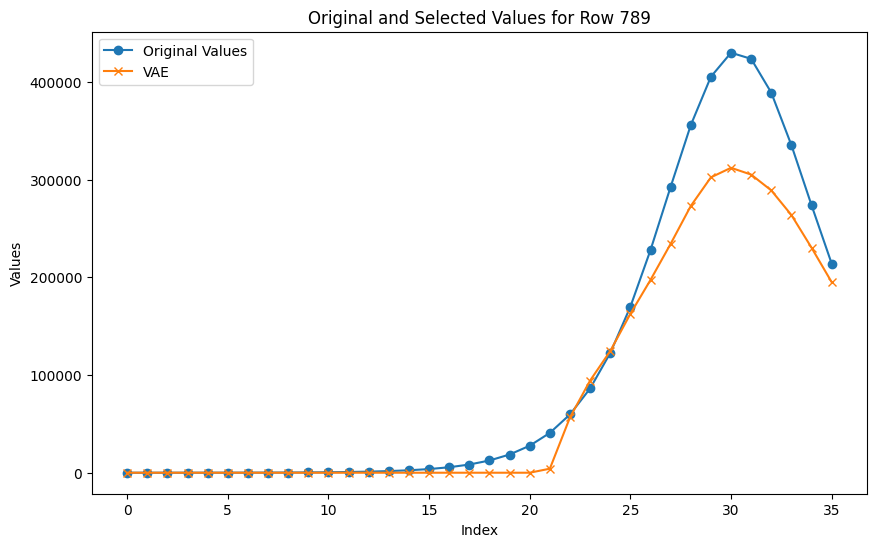

In [ ]:
# Визуализация результатов
fig, ax = plt.subplots(figsize=(10, 6))

# Построение графика для исходного значения и выбранных значений
ax.plot(I, label='Original Values', marker='o')
ax.plot(range(len(I)), custom_predictions, label='VAE', marker='x')

# Добавление подписей и легенды
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title(f'Original and Selected Values for Row {selected_row_index}')
ax.legend()

# Отображение графика
plt.show()

###Тест 3

In [ ]:
#custom_data_input = [0.1, 0.1, 0.1]
#custom_data_input = [0.35, 0.16, 0.09]
custom_data_input = [0.9, 0.9, 0.1]
custom_predictions = model.predict(custom_data_input)

In [ ]:
# Пример использования функции
N = 5600044
E0 = 10
I0 = 10
R0 = 0
days = 360

S, E, I, R = seir_model(*custom_data_input, N, I0, E0, R0, days)
I = I[::10]

In [ ]:
coefs = [*custom_data_input, N, days]

In [ ]:
r2_score(I, custom_predictions)

0.9946403738413756

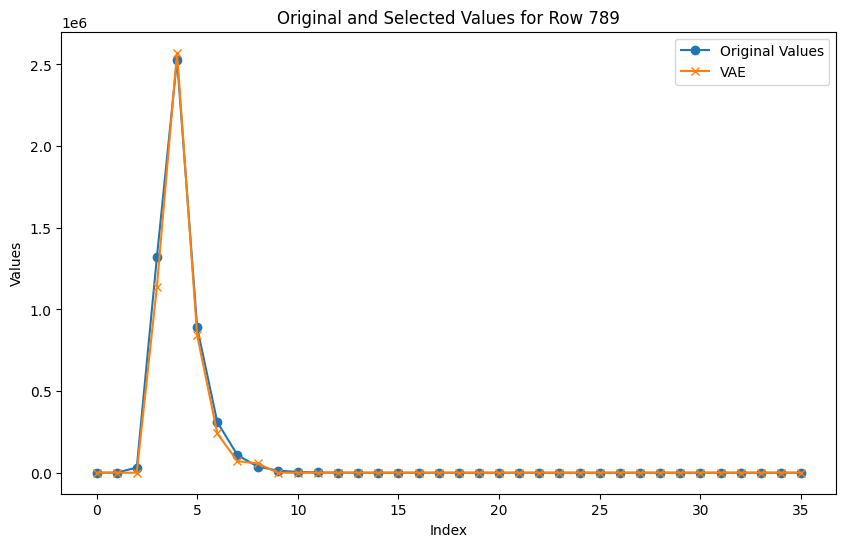

In [ ]:
# Визуализация результатов
fig, ax = plt.subplots(figsize=(10, 6))

# Построение графика для исходного значения и выбранных значений
ax.plot(I, label='Original Values', marker='o')
ax.plot(range(len(I)), custom_predictions, label='VAE', marker='x')

# Добавление подписей и легенды
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title(f'Original and Selected Values for Row {selected_row_index}')
ax.legend()

# Отображение графика
plt.show()

###Логи

Не всегда работают хз почему, мб строку случайно удалил где-то

In [ ]:
%tensorboard --logdir=logs

UsageError: Line magic function `%tensorboard` not found.


#ИДЕИ
1) Закодировать количество дней в меньшую размерность: написать нейронку (опять VAE), которая уменьшает размерность выходных данных

2) Обучать две или даже три модели, в зависимости от размера данных

https://discuss.pytorch.org/t/correct-implementation-of-vae-loss/146750

#Что ещё можно сделать:


*   Домножить параметры a b g на 10\100\1000
*   Увеличить количество эпох
*   Но тогда надо бы и уменьшить кол-во нейронов
*   Навернуть Conv



#Что показало плохой результат
1) Обучение на данных с 0.05 - 0.95 и проверка на 0.1 - 1

Метрика лучше, визуально графики хуже, видимо точность за счёт последних значений

2) Увеличение learning rate и уменьшение батча

# Что дало хороший результат
1) Подбор функций активации  

Лучше leaky_ReLU подобрать не удалось

2)  Увеличение количества эпох

После 1500 разница не особо велика, хотя, вроде, стало стабильнее